In [62]:
#Load packages
import pandas as pd
import numpy as np

#Load your exported files (update paths as needed)
actuals = pd.read_excel("ibes_actuals.xlsx")
forecasts = pd.read_excel("ibes_forecasts.xlsx")

#Clean and rename relevant columns
actuals = actuals.rename(columns={
    'Official Ticker Symbol': 'ticker',
    'Period End Date, SAS Format': 'fpedats',
    'Announce Date, SAS Format': 'anndats_act',
    'Actual Value': 'actual_eps'
})

forecasts = forecasts.rename(columns={
    'Official Ticker Symbol': 'ticker',
    'Forecast Period End Date, SAS Format': 'fpedats',
    'Announce Date, SAS Format': 'forecast_date',
    'Estimate Value': 'forecast_eps',
    'Analyst Code': 'analyst_id'
})

#Convert date fields to datetime
actuals['fpedats'] = pd.to_datetime(actuals['fpedats'])
actuals['anndats_act'] = pd.to_datetime(actuals['anndats_act'])

forecasts['fpedats'] = pd.to_datetime(forecasts['fpedats'])
forecasts['forecast_date'] = pd.to_datetime(forecasts['forecast_date'])

#Merge on (ticker, fpedats)
merged = forecasts.merge(actuals[['ticker', 'fpedats', 'anndats_act', 'actual_eps']],
on=['ticker', 'fpedats'],
how='inner')

#Keep only forecasts made BEFORE actual EPS announcement
merged = merged[merged['forecast_date'] < merged['anndats_act']]

# Group by quarter to get forecast stats
grouped = merged.groupby(['ticker', 'fpedats']).agg(
    mean_forecast=('forecast_eps', 'mean'),
    std_forecast=('forecast_eps', 'std'),
    num_analysts=('forecast_eps', 'count'),
    actual_eps=('actual_eps', 'first'),
    anndats_act=('anndats_act', 'first')
).reset_index()

#Filter out thin estimates (e.g., less than 3 forecasts or very low std)
grouped = grouped[(grouped['num_analysts'] >= 3) & (grouped['std_forecast'] > 0.001)]

#Compute SUE
grouped['SUE'] = (grouped['actual_eps'] - grouped['mean_forecast']) / grouped['std_forecast']

# Export final dataset
grouped.to_csv("ibes_sue_output.csv", index=False)

#Optional: Preview
grouped.head(10)


,ticker,fpedats,mean_forecast,std_forecast,num_analysts,actual_eps,anndats_act,SUE
4,AAPL,2000-12-31,0.002385,0.008698,54,-0.0130,2001-02-15,-1.768871
5,AAPL,2001-03-31,0.004087,0.003835,54,0.0020,2001-04-18,-0.544139
6,AAPL,2001-06-30,0.004228,0.002781,67,0.0030,2001-07-18,-0.441708
7,AAPL,2001-09-30,0.004403,0.001988,72,0.0032,2001-10-17,-0.605000
8,AAPL,2001-12-31,0.003119,0.001508,54,0.0020,2002-01-16,-0.741858
11,AAPL,2002-09-30,0.002406,0.001247,63,0.0004,2002-10-16,-1.608716
12,AAPL,2002-12-31,0.002048,0.001434,42,0.0005,2003-01-15,-1.078886
20,AAPL,2004-12-31,0.006196,0.001968,97,0.0125,2005-01-12,3.203797
21,AAPL,2005-03-31,0.005875,0.002104,137,0.0121,2005-04-13,2.958542
22,AAPL,2005-06-30,0.007257,0.002647,140,0.0132,2005-07-13,2.245171


In [63]:
# Basic dataset diagnostics
print("Number of firm-quarters:", len(grouped))
print("Number of unique firms:", grouped['ticker'].nunique())
print("Time range:", grouped['fpedats'].min(), "to", grouped['fpedats'].max())


Number of firm-quarters: 4590
Number of unique firms: 50
Time range: 1999-12-31 00:00:00 to 2023-11-30 00:00:00


In [64]:
# Distributional statistics
sue_stats = grouped['SUE'].agg(['mean', 'median', 'std'])
sue_skew = grouped['SUE'].skew()
sue_kurt = grouped['SUE'].kurtosis()

print("SUE Distribution Summary:")
print(sue_stats)
print("Skewness:", sue_skew)
print("Kurtosis:", sue_kurt)


SUE Distribution Summary:
mean      0.468526
median    0.336675
std       1.617760
Name: SUE, dtype: float64
Skewness: 0.5315248062151321
Kurtosis: 3.822131577812498


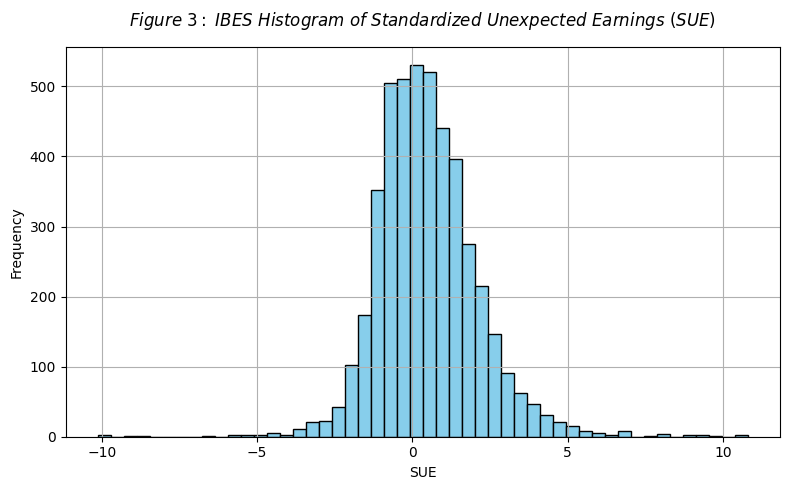

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(grouped['SUE'], bins=50, color='skyblue', edgecolor='black')
plt.title(r"$\it{Figure\ 3:\ IBES\ Histogram\ of\ Standardized\ Unexpected\ Earnings\ (SUE)}$",  x=0.5, pad=15) 
plt.xlabel("SUE")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()  
plt.show()

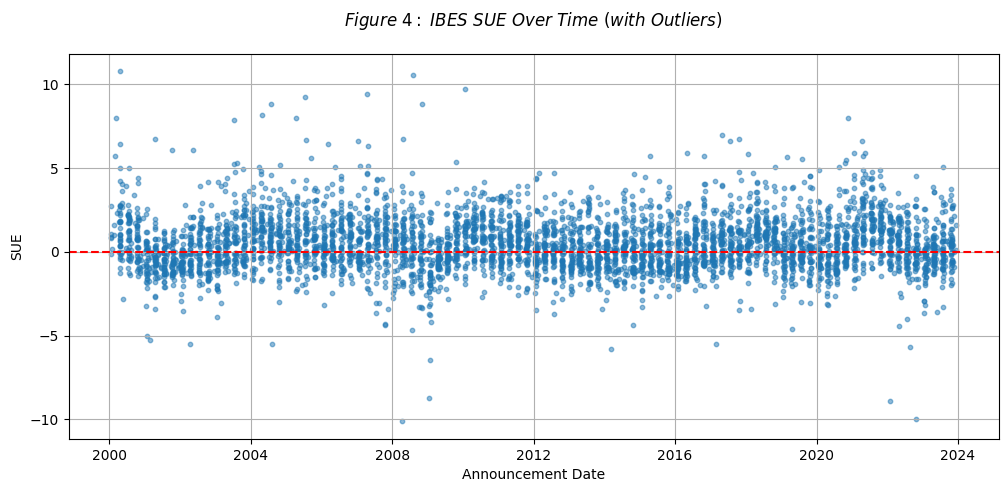

In [66]:
# Optional: identify key shock periods like 2008–09, 2020
grouped['year'] = grouped['anndats_act'].dt.year

plt.figure(figsize=(12, 5))
plt.scatter(grouped['anndats_act'], grouped['SUE'], alpha=0.5, s=10)
plt.title(r"$\it{Figure\ 4:\ IBES\ SUE\ Over\ Time\ (with\ Outliers)}$", x=0.5, pad=20)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Announcement Date")
plt.ylabel("SUE")
plt.grid(True)
plt.show()


In [67]:
# Ensure anndats_act is datetime
grouped['anndats_act'] = pd.to_datetime(grouped['anndats_act'])

# Assign deciles *within each announcement quarter*
grouped['year_quarter'] = grouped['anndats_act'].dt.to_period('Q')

# Sort SUE into deciles per quarter
grouped['decile'] = grouped.groupby('year_quarter')['SUE'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
)


In [68]:
# Mean SUE by decile (pooled)
sue_summary = grouped.groupby('decile')['SUE'].agg(['mean', 'median', 'std'])
print(sue_summary)


            mean    median       std
decile                              
1      -1.825890 -1.611258  1.183398
2      -0.851426 -0.876434  0.537164
3      -0.459767 -0.519026  0.533414
4      -0.133382 -0.155444  0.568658
5       0.188736  0.216644  0.562218
6       0.505002  0.477466  0.603165
7       0.848438  0.825343  0.594477
8       1.266955  1.286617  0.621413
9       1.849736  1.850147  0.716757
10      3.306141  3.011161  1.499807


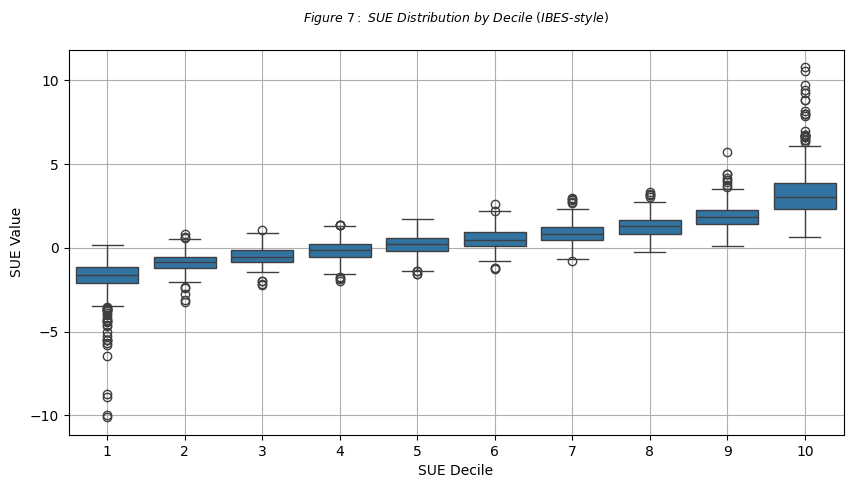

In [71]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.boxplot(x='decile', y='SUE', data=grouped)
plt.title(r"$\it{Figure\ 7:\ SUE\ Distribution\ by\ Decile\ (IBES\text{-}style)}$", x=0.5, pad=20, fontsize=9)
plt.xlabel("SUE Decile")
plt.ylabel("SUE Value")
plt.grid(True)
plt.show()


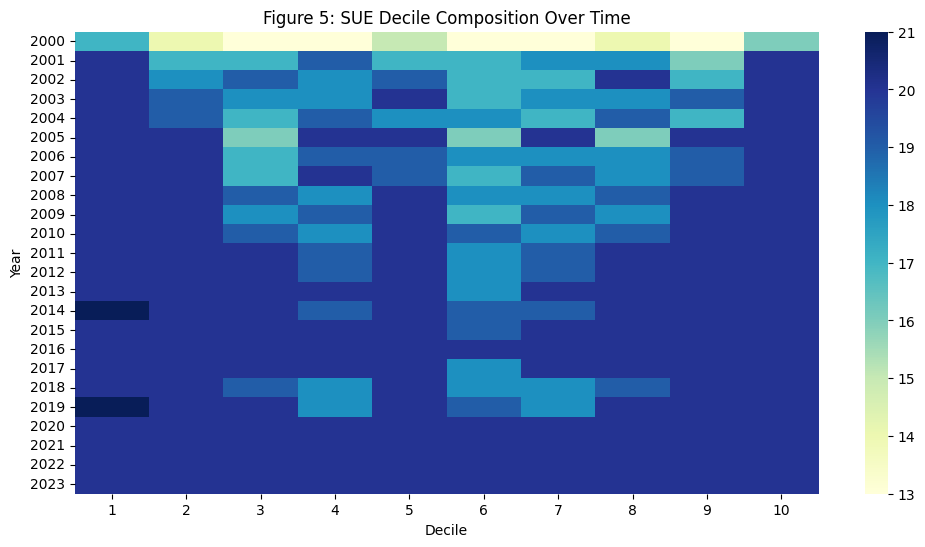

In [9]:
# Count firms per decile by year
decile_heatmap = grouped.groupby([grouped['anndats_act'].dt.year, 'decile']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(decile_heatmap, cmap='YlGnBu', annot=False)
plt.title("Figure 5: SUE Decile Composition Over Time")
plt.xlabel("Decile")
plt.ylabel("Year")
plt.show()


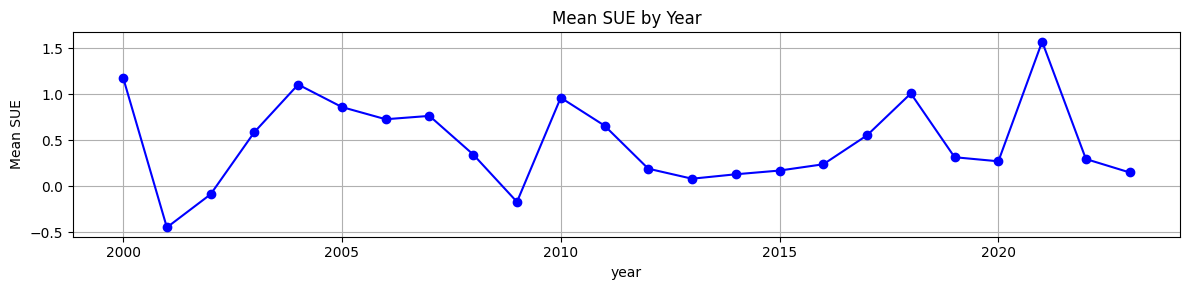

In [10]:
import matplotlib.pyplot as plt

# Ensure datetime is in correct format
grouped['anndats_act'] = pd.to_datetime(grouped['anndats_act'])

# Extract year
grouped['year'] = grouped['anndats_act'].dt.year

# Compute annual mean SUE
annual_sue = grouped.groupby('year')['SUE'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 3))
plt.plot(annual_sue['year'], annual_sue['SUE'], marker='o', color='blue')
plt.title("Mean SUE by Year")
plt.xlabel("year")
plt.ylabel("Mean SUE")
plt.grid(True)
plt.tight_layout()
plt.show()


            mean    median       std  count
decile                                     
1      -1.825890 -1.611258  1.183398    479
2      -0.851426 -0.876434  0.537164    467
3      -0.459767 -0.519026  0.533414    449
4      -0.133382 -0.155444  0.568658    454
5       0.188736  0.216644  0.562218    467
6       0.505002  0.477466  0.603165    434
7       0.848438  0.825343  0.594477    448
8       1.266955  1.286617  0.621413    456
9       1.849736  1.850147  0.716757    460
10      3.306141  3.011161  1.499807    476


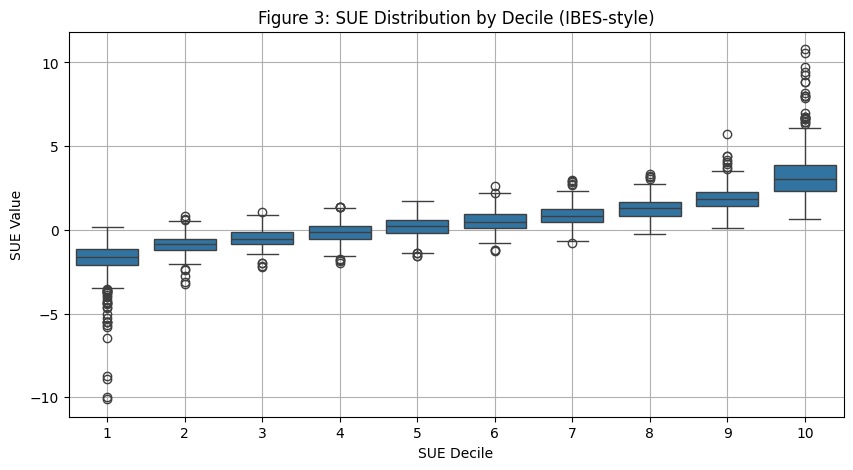

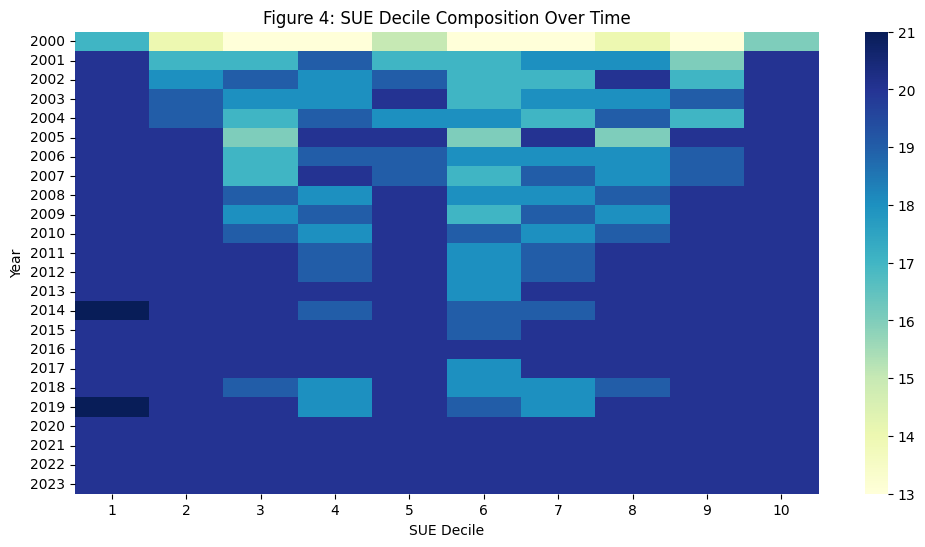

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("ibes_sue_output.csv")
df['anndats_act'] = pd.to_datetime(df['anndats_act'])
df['year_quarter'] = df['anndats_act'].dt.to_period('Q')

# Assign SUE deciles within each announcement quarter
df['decile'] = df.groupby('year_quarter')['SUE'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
)

# Print summary by decile
print(df.groupby('decile')['SUE'].agg(['mean', 'median', 'std', 'count']))

# Boxplot of SUE by Decile
plt.figure(figsize=(10, 5))
sns.boxplot(x='decile', y='SUE', data=df)
plt.title("Figure 3: SUE Distribution by Decile (IBES-style)")
plt.xlabel("SUE Decile")
plt.ylabel("SUE Value")
plt.grid(True)
plt.show()

# Heatmap of Firm Distribution by Year and Decile
df['year'] = df['anndats_act'].dt.year
heatmap_data = df.groupby(['year', 'decile']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
plt.title("Figure 4: SUE Decile Composition Over Time")
plt.xlabel("SUE Decile")
plt.ylabel("Year")
plt.show()


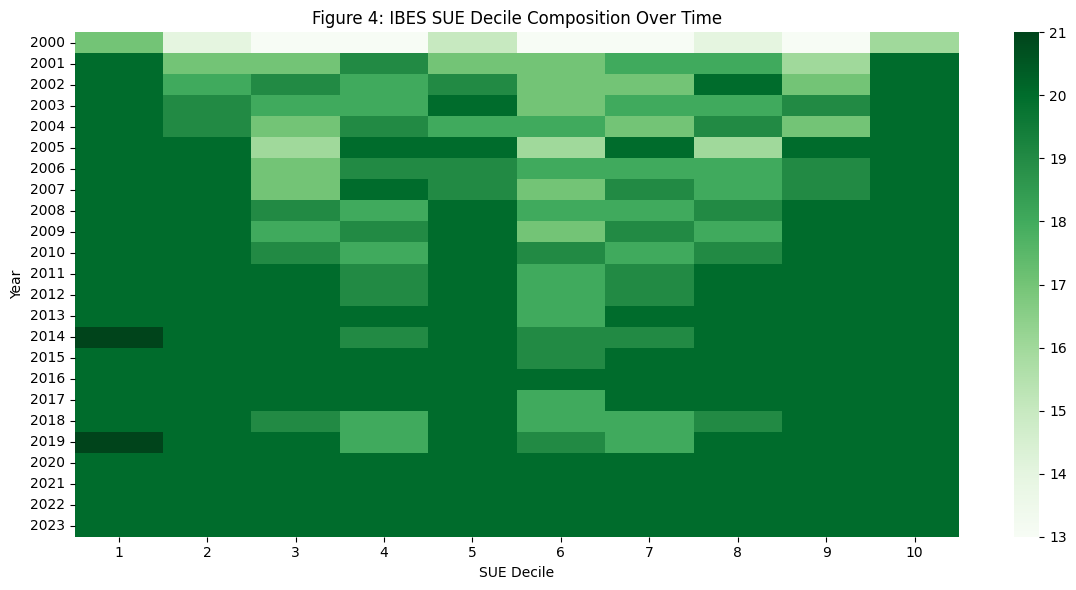

In [12]:
# GREEN THEME HEATMAP FOR SUE DECILES
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(decile_heatmap, cmap='Greens', annot=False)
plt.title("Figure 4: IBES SUE Decile Composition Over Time")
plt.xlabel("SUE Decile")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Load datasets
ibes = pd.read_csv("ibes_sue_output.csv")
crsp = pd.read_excel("CRSP Data.xlsx")

# Clean formats
ibes['anndats_act'] = pd.to_datetime(ibes['anndats_act'])
crsp['Names Date'] = pd.to_datetime(crsp['Names Date'])

ibes['ticker'] = ibes['ticker'].str.upper()
crsp['Ticker Symbol'] = crsp['Ticker Symbol'].str.upper()

# Initialize empty list for storing merged segments
merged_list = []

# Match by ticker and within [+1, +60] calendar days of announcement
for i, row in ibes.iterrows():
    ticker = row['ticker']
    ann_date = row['anndats_act']
    window_start = ann_date + pd.Timedelta(days=1)
    window_end = ann_date + pd.Timedelta(days=60)
    
    temp_crsp = crsp[
        (crsp['Ticker Symbol'] == ticker) &
        (crsp['Names Date'] >= window_start) &
        (crsp['Names Date'] <= window_end)
    ].copy()
    
    if not temp_crsp.empty:
        temp_crsp['anndats_act'] = ann_date
        temp_crsp['SUE'] = row['SUE']
        temp_crsp['fpedats'] = row['fpedats']
        merged_list.append(temp_crsp)

# Combine all matched rows
merged_final = pd.concat(merged_list, ignore_index=True)

# Export merged dataset
merged_final.to_excel("merged_ibes_crsp_returns.xlsx", index=False)

#  Diagnostic prints
print("Merged Records:", len(merged_final))
print("Unique Firms:", merged_final['Ticker Symbol'].nunique())
print(" Date Range:", merged_final['Names Date'].min(), "to", merged_final['Names Date'].max())


Merged Records: 188391
Unique Firms: 50
 Date Range: 2000-01-19 00:00:00 to 2023-12-29 00:00:00


Sample of SUE decile mapping:
        SUE  sue_decile
0 -1.768871           1
1 -1.768871           1
2 -1.768871           1
3 -1.768871           1
4 -1.768871           1

Event window shape (should be post-announcement only):
(188391, 15)


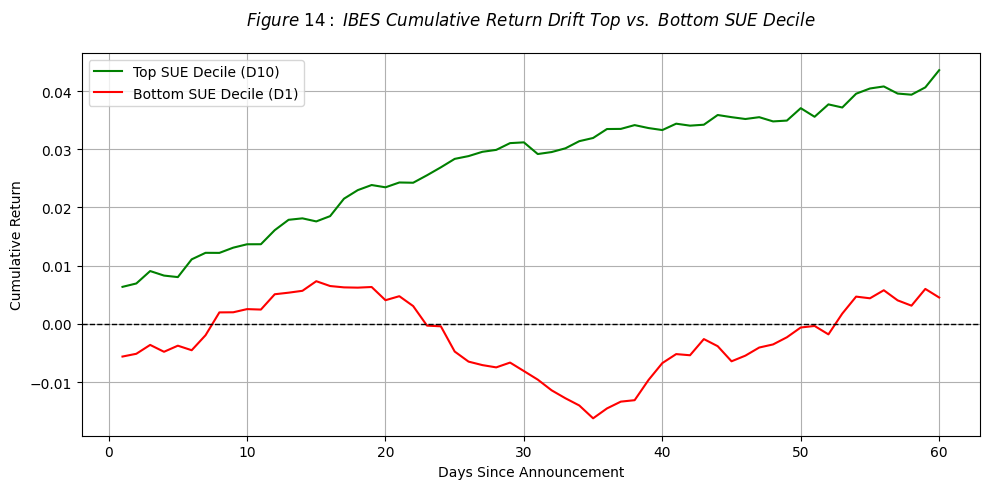

C:\Users\nairp\AppData\Local\Temp\ipykernel_31336\682860846.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=car_by_decile.index, y=car_by_decile.values, palette="viridis")


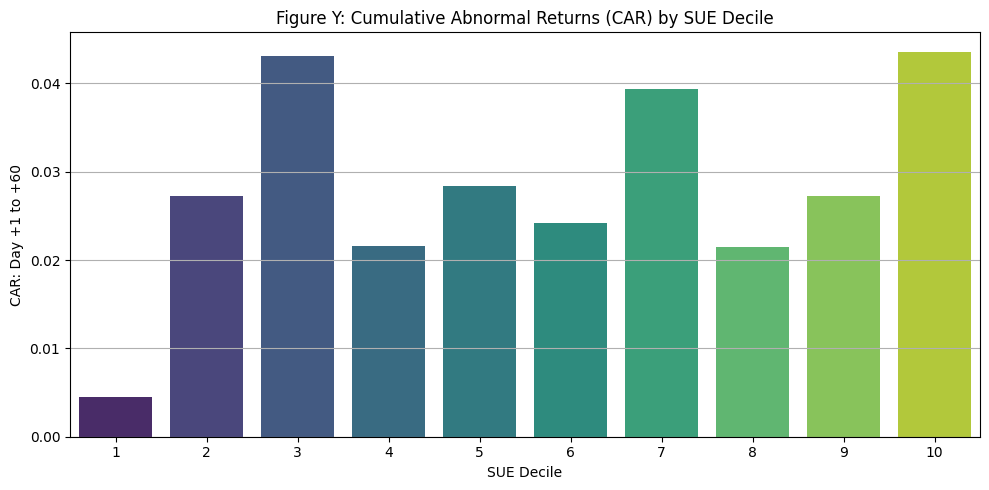

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Load merged dataset
df = pd.read_excel("merged_ibes_crsp_returns.xlsx")

# Ensure correct dtypes
df['Names Date'] = pd.to_datetime(df['Names Date'])
df['anndats_act'] = pd.to_datetime(df['anndats_act'])
df['fpedats'] = pd.to_datetime(df['fpedats'])

# STEP 1: Create SUE deciles
df['sue_decile'] = pd.qcut(df['SUE'], 10, labels=False) + 1  # 1 = bottom, 10 = top

# STEP 2: Compute event window relative to announcement
df['event_day'] = (df['Names Date'] - df['anndats_act']).dt.days
event_window = df[(df['event_day'] >= 1) & (df['event_day'] <= 60)].copy()

# STEP 3: Print check
print("Sample of SUE decile mapping:")
print(df[['SUE', 'sue_decile']].dropna().head())

print("\nEvent window shape (should be post-announcement only):")
print(event_window.shape)

# STEP 4: Graph 1 — Top vs. Bottom SUE Decile Drift
top = event_window[event_window['sue_decile'] == 10].groupby('event_day')['Returns'].mean().cumsum()
bottom = event_window[event_window['sue_decile'] == 1].groupby('event_day')['Returns'].mean().cumsum()

plt.figure(figsize=(10, 5))
plt.plot(top.index, top, label='Top SUE Decile (D10)', color='green')
plt.plot(bottom.index, bottom, label='Bottom SUE Decile (D1)', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(r"$\it{Figure\ 14:\ IBES\ Cumulative\ Return\ Drift\ Top\ vs.\ Bottom\ SUE\ Decile}$",
          x=0.5,  # Center the title
          pad=20,  # Add 20pt space above plot
          fontsize=12)  # Set font size
plt.xlabel("Days Since Announcement")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 5: Graph 2 — CAR by Decile (mean CAR from day +1 to +60)
car_by_decile = (
    event_window.groupby(['sue_decile', 'event_day'])['Returns']
    .mean()
    .groupby('sue_decile')
    .cumsum()
    .groupby('sue_decile')
    .last()
)

plt.figure(figsize=(10, 5))
sns.barplot(x=car_by_decile.index, y=car_by_decile.values, palette="viridis")
plt.title("Figure Y: Cumulative Abnormal Returns (CAR) by SUE Decile")
plt.xlabel("SUE Decile")
plt.ylabel("CAR: Day +1 to +60")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\nairp\AppData\Local\Temp\ipykernel_31336\2079363934.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  car_by_day = df_window.groupby(['SUE Decile', 'event_day'])['Returns'].mean().reset_index()


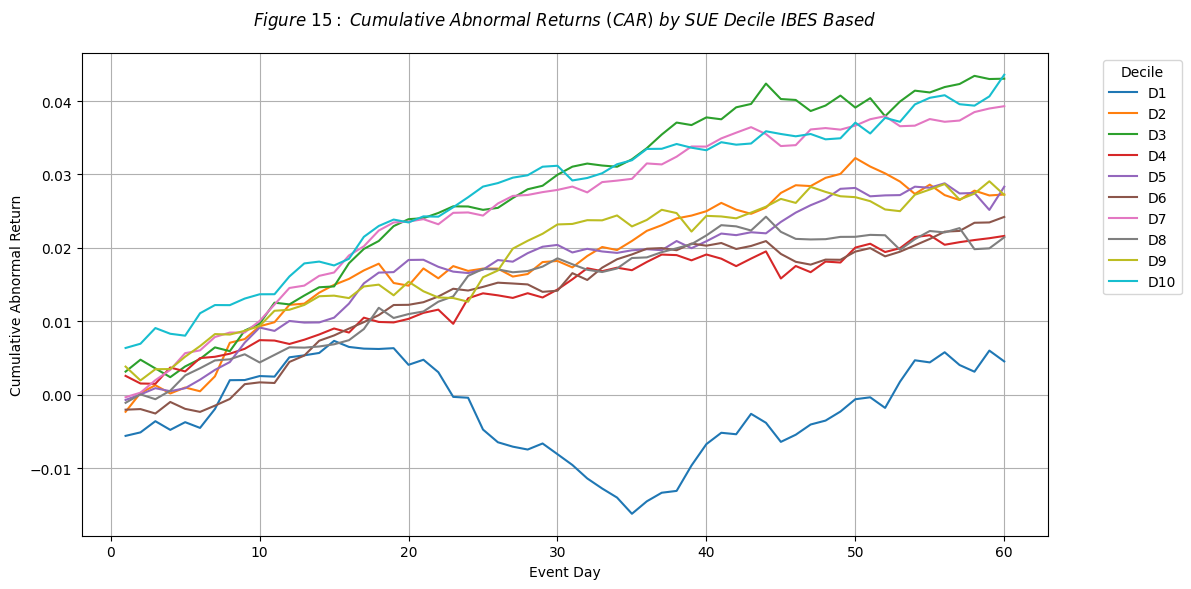

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged Excel file
df = pd.read_excel("merged_ibes_crsp_returns.xlsx")  # Change path if needed

# Ensure proper datetime conversion
df['Names Date'] = pd.to_datetime(df['Names Date'])
df['anndats_act'] = pd.to_datetime(df['anndats_act'], errors='coerce')

# Filter out rows with missing announcement dates or returns
df = df.dropna(subset=['anndats_act', 'Returns'])

# Calculate the event day relative to the announcement
df['event_day'] = (df['Names Date'] - df['anndats_act']).dt.days

# Limit to the post-announcement window [+1, +60]
df_window = df[(df['event_day'] >= 1) & (df['event_day'] <= 60)]

# Create decile categories using SUE
df_window['SUE Decile'] = pd.qcut(df_window['SUE'], 10, labels=[f'D{i}' for i in range(1, 11)])

# Group by event day and decile, then compute mean returns
car_by_day = df_window.groupby(['SUE Decile', 'event_day'])['Returns'].mean().reset_index()

# Pivot: event_day as index, deciles as columns
pivot_car = car_by_day.pivot(index='event_day', columns='SUE Decile', values='Returns')

# Calculate cumulative returns (CAR) over the event window
cumulative_car = pivot_car.cumsum()

# Plot CAR by decile with color lines
plt.figure(figsize=(12, 6))
for decile in cumulative_car.columns:
    plt.plot(cumulative_car.index, cumulative_car[decile], label=decile)
plt.title(r"$\it{Figure\ 15:\ Cumulative\ Abnormal\ Returns\ (CAR)\ by\ SUE\ Decile\ IBES\ Based}$",
          x=0.5,    # Center the title
          pad=20,   # Add 20pt space above plot
          fontsize=12)
plt.xlabel('Event Day')
plt.ylabel('Cumulative Abnormal Return')
plt.legend(title='Decile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import statsmodels.api as sm

# Load your data
merged_df = pd.read_excel("merged_ibes_crsp_returns.xlsx")  # Merged IBES + CRSP
ff3_df = pd.read_csv("FF3 IBES.csv")  # Fama-French 3-Factor

# Parse dates
merged_df['anndats_act'] = pd.to_datetime(merged_df['anndats_act'])
ff3_df['Date'] = pd.to_datetime(ff3_df['Date'])

# Group returns to compute CAR at announcement-event level
car_df = (
    merged_df.groupby(['PERMNO', 'fpedats'])
    .agg({'Returns': 'sum', 'SUE': 'first', 'anndats_act': 'first'})
    .rename(columns={'Returns': 'CAR'})
    .reset_index()
)

# Merge CAR + SUE with FF3
reg_df = pd.merge(car_df, ff3_df, left_on='anndats_act', right_on='Date', how='inner')

# Drop NAs
reg_df = reg_df.dropna(subset=['CAR', 'SUE', 'Mkt-RF', 'SMB', 'HML'])

# -----------------------
# REGRESSION 1: CAR ~ SUE
# -----------------------
X1 = sm.add_constant(reg_df['SUE'])
model1 = sm.OLS(reg_df['CAR'], X1).fit()

print("REGRESSION 1: CAR ~ SUE")
print(model1.summary())

# --------------------------------------
# REGRESSION 2: CAR ~ SUE + FF3 Controls
# --------------------------------------
X2 = sm.add_constant(reg_df[['SUE', 'Mkt-RF', 'SMB', 'HML']])
model2 = sm.OLS(reg_df['CAR'], X2).fit()

print("\nREGRESSION 2: CAR ~ SUE + FF3")
print(model2.summary())


REGRESSION 1: CAR ~ SUE
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.276
Date:                Thu, 26 Jun 2025   Prob (F-statistic):            0.00234
Time:                        15:44:12   Log-Likelihood:                 3753.1
No. Observations:                4587   AIC:                            -7502.
Df Residuals:                    4585   BIC:                            -7489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0179      0

In [17]:
model2 = sm.OLS(reg_df['CAR'], X2).fit(cov_type='HC3')
print(model2.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.008
Date:                Thu, 26 Jun 2025   Prob (F-statistic):            0.00301
Time:                        15:44:12   Log-Likelihood:                 3758.8
No. Observations:                4587   AIC:                            -7508.
Df Residuals:                    4582   BIC:                            -7475.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0180      0.002     10.415      0.0

In [18]:
import pandas as pd
import numpy as np

# --- Load merged data ---
df = pd.read_excel("merged_ibes_crsp_returns.xlsx")

# --- Convert date column ---
df['Names Date'] = pd.to_datetime(df['Names Date'])
df['anndats_act'] = pd.to_datetime(df['anndats_act'])

# --- Sort for safety ---
df = df.sort_values(['PERMNO', 'Names Date'])

# --- Event Window Definition ---
L1 = 60   # Day +60 after earnings
L0 = 1    # Day +1 after earnings
T1 = -60  # Estimation window start
T0 = -6   # Estimation window end

# --- Initialize list for results ---
scar_results = []

# --- Loop over each firm-date combination ---
unique_events = df[['PERMNO', 'anndats_act']].drop_duplicates()

for _, row in unique_events.iterrows():
    permno = row['PERMNO']
    ann_date = row['anndats_act']
    
    # Subset for the firm
    firm_data = df[df['PERMNO'] == permno]
    
    # --- Estimation Window: [T1, T0] ---
    est_window = firm_data[(firm_data['Names Date'] >= ann_date + pd.Timedelta(days=T1)) &
                           (firm_data['Names Date'] <= ann_date + pd.Timedelta(days=T0))]
    
    # --- Event Window: [L0, L1] ---
    event_window = firm_data[(firm_data['Names Date'] >= ann_date + pd.Timedelta(days=L0)) &
                             (firm_data['Names Date'] <= ann_date + pd.Timedelta(days=L1))]
    
    if len(est_window) < 10 or len(event_window) < 10:
        continue  # Skip if insufficient data
    
    # --- Estimation Mean and Std Dev of Returns ---
    mu = est_window['Returns'].mean()
    sigma = est_window['Returns'].std()
    
    if sigma == 0 or np.isnan(sigma):
        continue  # Skip if standard deviation is undefined
    
    # --- Calculate Abnormal Returns ---
    event_window = event_window.copy()
    event_window['AR'] = event_window['Returns'] - mu
    
    # --- Calculate CAR and SCAR ---
    CAR = event_window['AR'].sum()
    SCAR = -CAR / (sigma * np.sqrt(len(event_window)))
    
    scar_results.append({
        'PERMNO': permno,
        'ann_date': ann_date,
        'CAR': CAR,
        'SCAR': SCAR
    })

# --- Create DataFrame ---
scar_df = pd.DataFrame(scar_results)

# --- Drop NaN and calculate J2 statistic ---
scar_df = scar_df.dropna()
n = len(scar_df)
J2_stat = scar_df['SCAR'].mean() * np.sqrt(n)

# --- Print Diagnostics ---
print("SCAR + J2 Test Summary")
print(f"Number of Valid Observations: {n}")
print(f"Mean SCAR: {scar_df['SCAR'].mean():.4f}")
print(f"J2 Statistic: {J2_stat:.4f}")


# Optional: Save to CSV
scar_df.to_excel("scar_j2_output.xlsx", index=False)

SCAR + J2 Test Summary
Number of Valid Observations: 4449
Mean SCAR: 0.0375
J2 Statistic: 2.5044


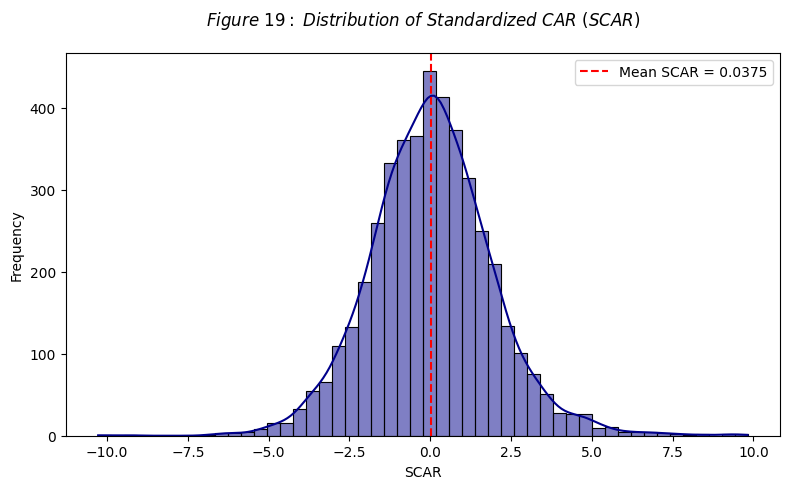

In [77]:
# ------------------------
# 1. SCAR Distribution
# ------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(scar_df['SCAR'], bins=50, kde=True, color='darkblue')
plt.axvline(scar_df['SCAR'].mean(), color='red', linestyle='--', label=f"Mean SCAR = {scar_df['SCAR'].mean():.4f}")
plt.title(r"$\it{Figure\ 19:\ Distribution\ of\ Standardized\ CAR\ (SCAR)}$",
          x=0.5,    # Center the title
          pad=20,   # Add 20pt space above plot
          fontsize=12)
plt.xlabel("SCAR")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()




In [20]:
import pandas as pd

# Load the SCAR/CAR data
scar_df = pd.read_excel("scar_j2_output.xlsx")

# Load the IBES+CRSP merged return and SUE data
ibes_df = pd.read_excel("merged_ibes_crsp_returns.xlsx")


In [21]:
# Convert 'ann_date' in scar_df to proper datetime
scar_df['ann_date'] = pd.to_datetime(scar_df['ann_date']).dt.date

# Convert 'anndats_act' in ibes_df to proper datetime (remove time)
ibes_df['anndats_act'] = pd.to_datetime(ibes_df['anndats_act']).dt.date


In [22]:
# Merge on both PERMNO and earnings announcement date
merged_df = pd.merge(
    scar_df,
    ibes_df,
    how='inner',
    left_on=['PERMNO', 'ann_date'],
    right_on=['PERMNO', 'anndats_act']
)


In [23]:
# Select only the needed variables for regression
regression_df = merged_df[['PERMNO', 'ann_date', 'CAR', 'SUE']]


In [24]:
# Save the merged dataset to Excel
merged_df.to_excel("scar_j2_with_ibes.xlsx", index=False)


In [79]:
import statsmodels.api as sm
import pandas as pd
import pandas as pd
import statsmodels.api as sm
!pip install linearmodels
from linearmodels.panel import PanelOLS

# Load the merged file
df = pd.read_excel('scar_j2_with_ibes.xlsx')

# Convert dates
df['ann_date'] = pd.to_datetime(df['ann_date'])
df['PERMNO'] = df['PERMNO'].astype(str)

# Multiply SCAR by -1 to reverse sign
df['SCAR'] = -df['SCAR']  # 🔁 SIGN FLIP

# Keep required variables and drop NA
df_model = df[['PERMNO', 'ann_date', 'SCAR', 'SUE']].dropna()

# Add constant
df_model['const'] = 1

# Set up X and y
X = df_model[['const', 'SUE']]
y = df_model['SCAR']

# Run OLS with clustering
model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': df_model['PERMNO']})

# Output
print(results.summary())

print("\n=== Coefficient Table ===")
print("Intercept:", results.params['const'])
print("SUE Coefficient:", results.params['SUE'])
print("Standard Error (SUE):", results.bse['SUE'])
print("P-Value (SUE):", results.pvalues['SUE'])

print("\nR-squared:", results.rsquared)
print("Adjusted R-squared:", results.rsquared_adj)

num_clusters = df['PERMNO'].nunique()
print("\nNumber of clusters (PERMNO):", num_clusters)

print("\n=== Descriptive Stats ===")
print(df[['SCAR', 'SUE']].describe())



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


                            OLS Regression Results                            
Dep. Variable:                   SCAR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.923
Date:                Thu, 26 Jun 2025   Prob (F-statistic):             0.0183
Time:                        19:36:42   Log-Likelihood:            -3.7644e+05
No. Observations:              182598   AIC:                         7.529e+05
Df Residuals:                  182596   BIC:                         7.529e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0214      0.020     -1.081      0.2

C:\Users\nairp\AppData\Local\Temp\ipykernel_31336\689344374.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SUE_decile', y='SCAR', data=df, inner='quartile', palette='viridis')


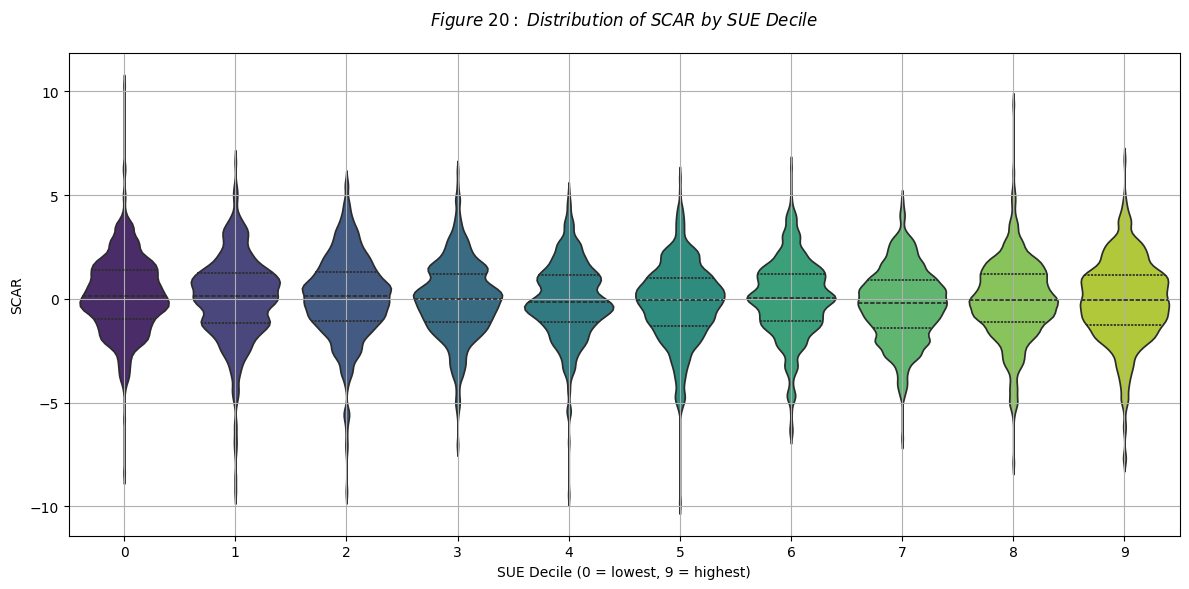

In [80]:
import seaborn as sns; import matplotlib.pyplot as plt; import pandas as pd

# Create SUE deciles
df['SUE_decile'] = pd.qcut(df['SUE'], 10, labels=False)

# Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='SUE_decile', y='SCAR', data=df, inner='quartile', palette='viridis')
plt.title(r"$\it{Figure\ 20:\ Distribution\ of\ SCAR\ by\ SUE\ Decile}$",
          x=0.5,    # Center the title
          pad=20,   # Add 20pt space above plot
          fontsize=12)
plt.xlabel('SUE Decile (0 = lowest, 9 = highest)')
plt.ylabel('SCAR')
plt.grid(True)
plt.tight_layout()
plt.show()


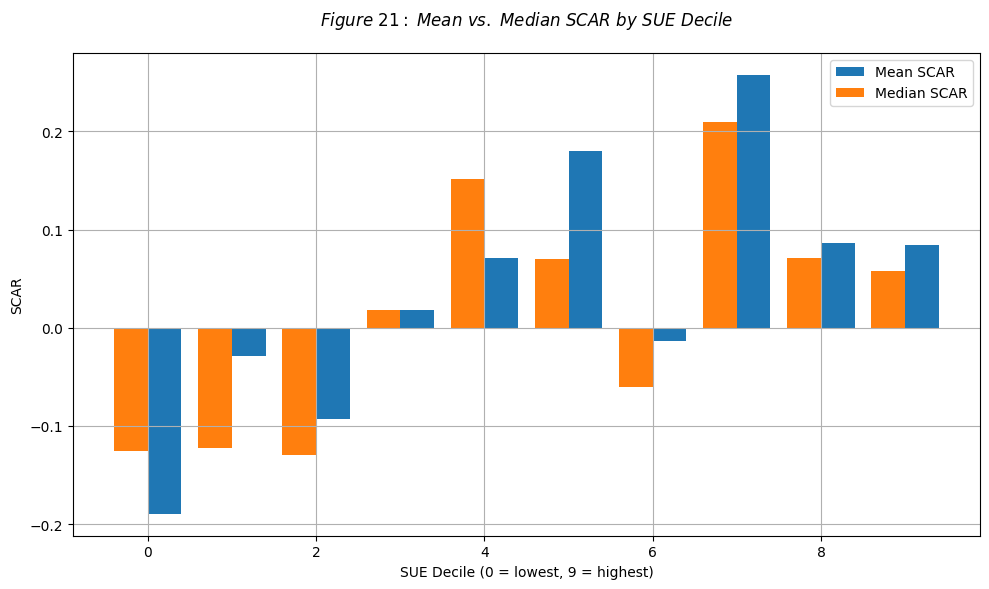

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel('scar_j2_with_ibes.xlsx')

# Drop NA values for relevant columns
df = df[['SUE', 'SCAR']].dropna()

# Step 1:  PEAD expectation
df['SCAR'] = df['SCAR']

#  Step 2: Create deciles based on SUE
df['SUE_decile'] = pd.qcut(df['SUE'], 10, labels=False, duplicates='drop')

# Step 3: Group by decile and calculate mean + median SCAR
grouped = df.groupby('SUE_decile')['SCAR'].agg(['mean', 'median']).reset_index()

# Step 4: Plot both Mean and Median SCAR by SUE Decile
plt.figure(figsize=(10, 6))
plt.bar(grouped['SUE_decile'], grouped['mean'], width=0.4, label='Mean SCAR', align='edge')
plt.bar(grouped['SUE_decile'] - 0.4, grouped['median'], width=0.4, label='Median SCAR', align='edge')
plt.title(r"$\it{Figure\ 21:\ Mean\ vs.\ Median\ SCAR\ by\ SUE\ Decile}$",
          x=0.5,    # Center the title
          pad=20,   # Add 20pt space above plot
          fontsize=12)
plt.xlabel('SUE Decile (0 = lowest, 9 = highest)')
plt.ylabel('SCAR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


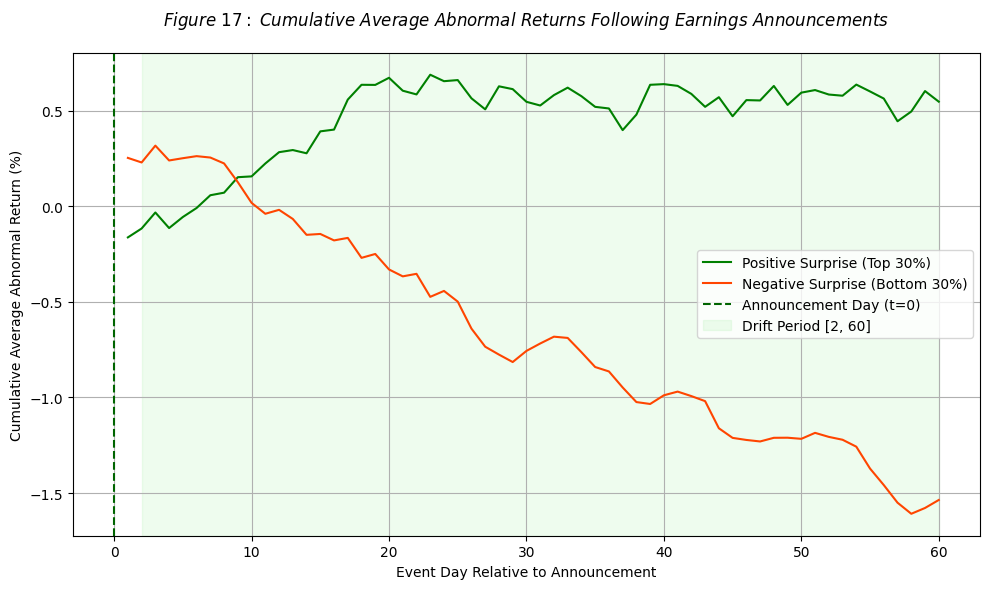

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# === 1. Load Data === #
ibes_df = pd.read_excel("merged_ibes_crsp_returns.xlsx", parse_dates=["anndats_act"])
ff3_df = pd.read_csv("FF3 IBES.csv", parse_dates=["Date"])

# Rename for merge compatibility
ff3_df.rename(columns={"Date": "Names Date"}, inplace=True)

# === 2. Merge returns and FF3 === #
ibes_df["Names Date"] = pd.to_datetime(ibes_df["Names Date"])
merged_df = pd.merge(ibes_df, ff3_df, on="Names Date", how="left")

# === 3. Calculate excess return === #
merged_df["Excess Return"] = merged_df["Returns"] * 100 - merged_df["RF"]  # returns in %

# === 4. Define windows === #
event_window = list(range(1, 61))         # +1 to +60
estimation_window = list(range(-60, -5))  # -60 to -6

# === 5. Loop per announcement === #
all_caar = []

for permno in merged_df["PERMNO"].unique():
    firm_df = merged_df[merged_df["PERMNO"] == permno].copy()
    for ann_date in firm_df["anndats_act"].dropna().unique():
        # Build event index
        firm_df["event_day"] = (firm_df["Names Date"] - pd.to_datetime(ann_date)).dt.days

        est_win = firm_df[firm_df["event_day"].isin(estimation_window)]
        evt_win = firm_df[firm_df["event_day"].isin(event_window)]

        # Skip if insufficient data
        if len(est_win) < 20 or len(evt_win) < 20:
            continue

        # FF3 regression in estimation window
        X = est_win[["Mkt-RF", "SMB", "HML"]]
        X = sm.add_constant(X)
        y = est_win["Excess Return"]
        model = sm.OLS(y, X).fit()
        alpha, beta_mkt, beta_smb, beta_hml = model.params

        # Predict normal returns for event window
        X_event = sm.add_constant(evt_win[["Mkt-RF", "SMB", "HML"]])
        normal_ret = X_event @ model.params
        abnormal_ret = evt_win["Excess Return"].values - normal_ret.values

        # Save abnormal returns with meta info
        for idx, day in enumerate(evt_win["event_day"].values):
            all_caar.append({
                "PERMNO": permno,
                "ann_date": ann_date,
                "event_day": day,
                "AR": abnormal_ret[idx],
                "SUE": firm_df["SUE"].iloc[0]  # assumes SUE is static over the event
            })

# === 6. Create CAARs === #
caar_df = pd.DataFrame(all_caar)
# Sort into top/bottom 30%
cutoff_top = caar_df["SUE"].quantile(0.70)
cutoff_bot = caar_df["SUE"].quantile(0.30)

top_df = caar_df[caar_df["SUE"] >= cutoff_top]
bot_df = caar_df[caar_df["SUE"] <= cutoff_bot]

top_caar = top_df.groupby("event_day")["AR"].mean().cumsum()
bot_caar = bot_df.groupby("event_day")["AR"].mean().cumsum()

# === 7. Plot CAAR === #
plt.figure(figsize=(10, 6))

# Change line colors here
plt.plot(top_caar.index, top_caar, label="Positive Surprise (Top 30%)", color="green")
plt.plot(bot_caar.index, bot_caar, label="Negative Surprise (Bottom 30%)", color="orangered")

# Change vertical line and drift zone styling
plt.axvline(x=0, linestyle="--", color="darkgreen", label="Announcement Day (t=0)")
plt.axvspan(2, 60, color='lightgreen', alpha=0.15, label="Drift Period [2, 60]")

# Labels and layout
plt.title(r"$\it{Figure\ 17:\ Cumulative\ Average\ Abnormal\ Returns\ Following\ Earnings\ Announcements}$",
          x=0.5,    # Center the title
          pad=20,   # Add 20pt space above plot
          fontsize=12)
plt.xlabel("Event Day Relative to Announcement")
plt.ylabel("Cumulative Average Abnormal Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [29]:
# Load the merged file
df = pd.read_excel('scar_j2_with_ibes.xlsx')

# Convert dates
df['ann_date'] = pd.to_datetime(df['ann_date'])
df['PERMNO'] = df['PERMNO'].astype(str)  # Ensure firm ID is string for clustering


In [30]:
# Keep only required variables and drop NA
df_model = df[['PERMNO', 'ann_date', 'SCAR', 'SUE']].dropna()




In [31]:
# Add constant for OLS
df_model['const'] = 1

# Independent and dependent variables
X = df_model[['const', 'SUE']]
y = df_model['SCAR']


In [32]:
# Run OLS with clustering by PERMNO
model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': df_model['PERMNO']})

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   SCAR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.923
Date:                Thu, 26 Jun 2025   Prob (F-statistic):             0.0183
Time:                        15:48:38   Log-Likelihood:            -3.7644e+05
No. Observations:              182598   AIC:                         7.529e+05
Df Residuals:                  182596   BIC:                         7.529e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0214      0.020      1.081      0.2

In [33]:

# Print the coefficient, std error, and p-value alone
print("\n=== Coefficient Table ===")
print("Intercept:", results.params['const'])
print("SUE Coefficient:", results.params['SUE'])
print("Standard Error (SUE):", results.bse['SUE'])
print("P-Value (SUE):", results.pvalues['SUE'])

# Print R-squared separately
print("\nR-squared:", results.rsquared)
print("Adjusted R-squared:", results.rsquared_adj)

# Print number of clusters
num_clusters = df['PERMNO'].nunique()
print("\nNumber of clusters (PERMNO):", num_clusters)

# Summary statistics of SCAR and SUE
print("\n=== Descriptive Stats ===")
print(df[['SCAR', 'SUE']].describe())



=== Coefficient Table ===
Intercept: 0.021385610789906747
SUE Coefficient: 0.03476884576700958
Standard Error (SUE): 0.014286643492489917
P-Value (SUE): 0.014946990314490143

R-squared: 0.0008687030376094418
Adjusted R-squared: 0.0008632312238952

Number of clusters (PERMNO): 55

=== Descriptive Stats ===
                SCAR            SUE
count  182598.000000  182598.000000
mean        0.037404       0.460713
std         1.902374       1.612654
min       -10.276047     -10.120745
25%        -1.167787      -0.580716
50%         0.006608       0.329262
75%         1.159985       1.345414
max         9.819733      10.558185


C:\Users\nairp\AppData\Local\Temp\ipykernel_31336\2692291571.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estimate_cond_vol)


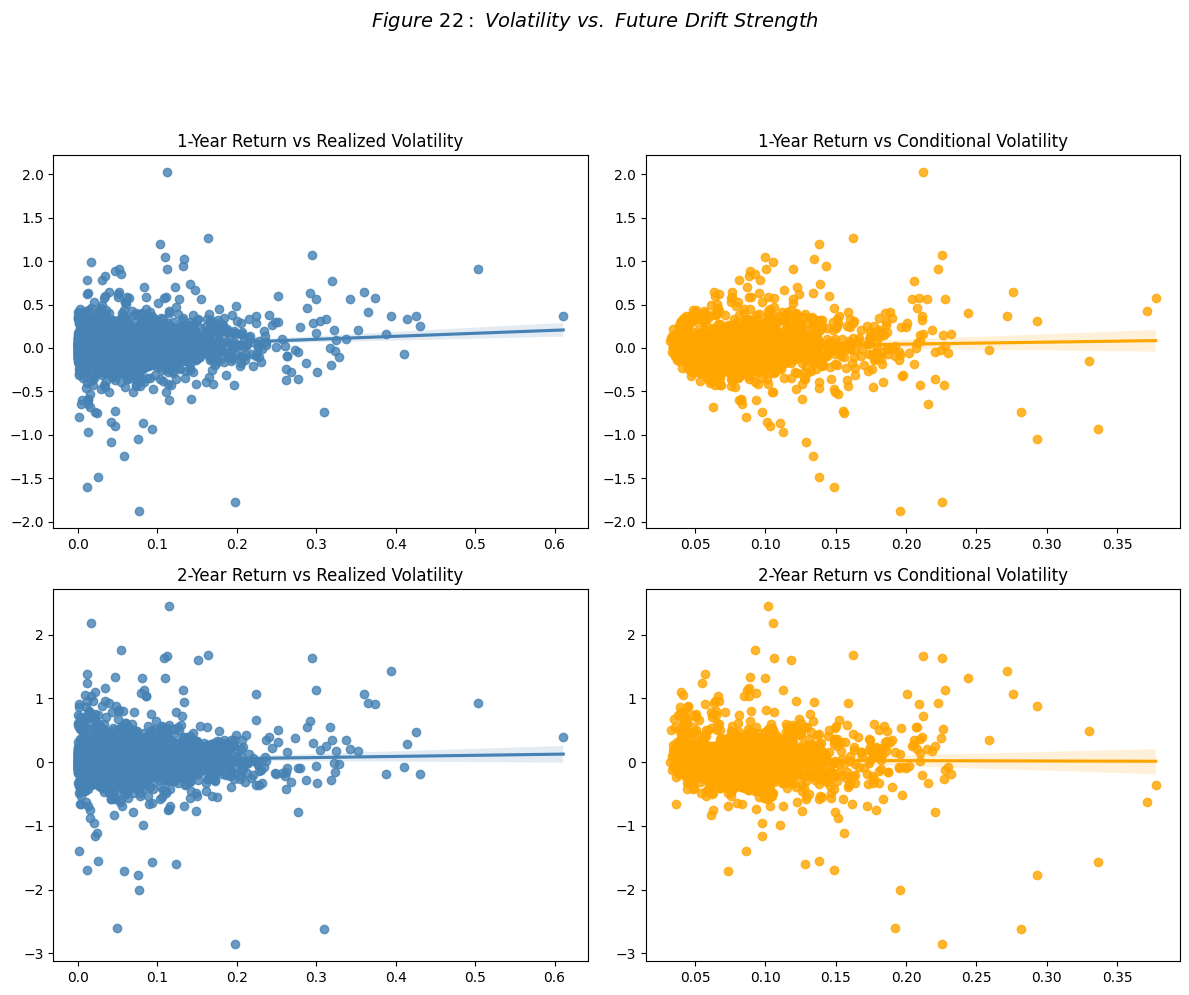

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model

# === Step 1: Load data ===
df = pd.read_excel("merged_panel_sue_ff3.xlsx")

# === Step 2: Filter event window [+1, +60] and compute excess return ===
event_window = df[(df['event_day'] >= 1) & (df['event_day'] <= 60)].copy()
event_window['excess_return'] = event_window['returns'] - event_window['RF']

# === Step 3: Estimate GARCH(1,1) conditional volatility ===
def estimate_cond_vol(group):
    if len(group) < 30:
        group['cond_vol'] = np.nan
        return group

    try:
        model = arch_model(group['excess_return'] * 100, vol='Garch', p=1, q=1, rescale=False)
        res = model.fit(disp='off')
        cond_vol = res.conditional_volatility / 100  # scale back
        group['cond_vol'] = cond_vol.values
    except:
        group['cond_vol'] = np.nan

    return group

event_window = (
    event_window.groupby('permno')
    .apply(estimate_cond_vol)
    .reset_index(drop=True)  # ✅ avoids duplicate columns
)

event_window = event_window.dropna(subset=['cond_vol'])


# === Step 4: Compute CARs and Volatility Aggregates ===
car_summary = (
    event_window.groupby(['permno', 'quarter'])
    .agg(
        car_1yr=('excess_return', 'sum'),
        realized_vol=('excess_return', 'std'),
        cond_vol=('cond_vol', 'mean')
    )
    .reset_index()
)

# Simulate "2-year" CARs using rolling window
car_summary['car_2yr'] = (
    car_summary.groupby('permno')['car_1yr'].transform(lambda x: x.rolling(2).sum())
)

car_summary = car_summary.dropna()

# === Step 5: Plotting ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(r"$\it{Figure\ 22:\ Volatility\ vs.\ Future\ Drift\ Strength}$",
             fontsize=14,
             y=1.02)

sns.regplot(data=car_summary, x='realized_vol', y='car_1yr', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title("1-Year Return vs Realized Volatility")

sns.regplot(data=car_summary, x='cond_vol', y='car_1yr', ax=axes[0, 1], color='orange')
axes[0, 1].set_title("1-Year Return vs Conditional Volatility")

sns.regplot(data=car_summary, x='realized_vol', y='car_2yr', ax=axes[1, 0], color='steelblue')
axes[1, 0].set_title("2-Year Return vs Realized Volatility")

sns.regplot(data=car_summary, x='cond_vol', y='car_2yr', ax=axes[1, 1], color='orange')
axes[1, 1].set_title("2-Year Return vs Conditional Volatility")

for ax in axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


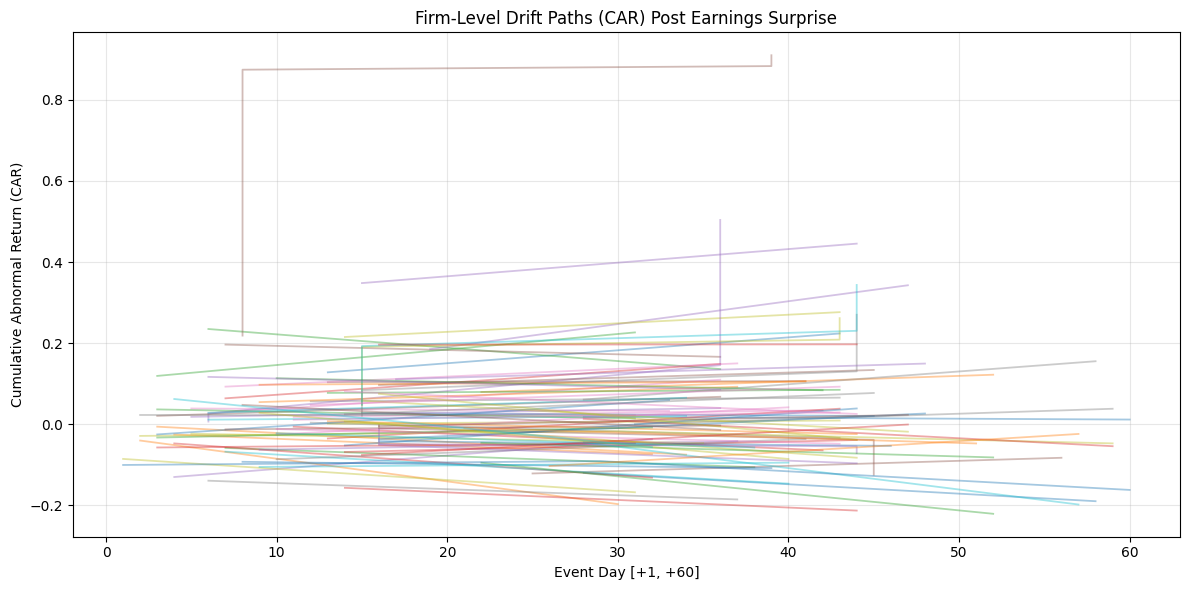

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the dataset ===
df = pd.read_excel("merged_panel_sue_ff3.xlsx")

# === Step 2: Focus only on event window [+1, +60] ===
event_window = df[(df['event_day'] >= 1) & (df['event_day'] <= 60)].copy()

# === Step 3: Compute Excess Return ===
event_window['excess_return'] = event_window['returns'] - event_window['RF']

# === Step 4: Filter for valid rows and deciles ===
event_window = event_window.dropna(subset=['excess_return', 'decile_8q'])

# === Step 5: Random sample of 100 firm-quarters ===
sample_keys = (
    event_window.groupby(['permno', 'quarter'])
    .size()
    .reset_index()
    .sample(n=100, random_state=42)[['permno', 'quarter']]
)

# === Step 6: Merge and sort ===
sample_data = pd.merge(event_window, sample_keys, on=['permno', 'quarter'])
sample_data.sort_values(by=['permno', 'quarter', 'event_day'], inplace=True)

# === Step 7: Plot with thicker lines ===
plt.figure(figsize=(12, 6))
for (firm, qtr), sub_df in sample_data.groupby(['permno', 'quarter']):
    sub_df = sub_df.sort_values('event_day')
    sub_df['car'] = sub_df['excess_return'].cumsum()
    plt.plot(sub_df['event_day'], sub_df['car'], alpha=0.4, linewidth=1.3)  # << THICKER LINES

plt.title("Firm-Level Drift Paths (CAR) Post Earnings Surprise")
plt.xlabel("Event Day [+1, +60]")
plt.ylabel("Cumulative Abnormal Return (CAR)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


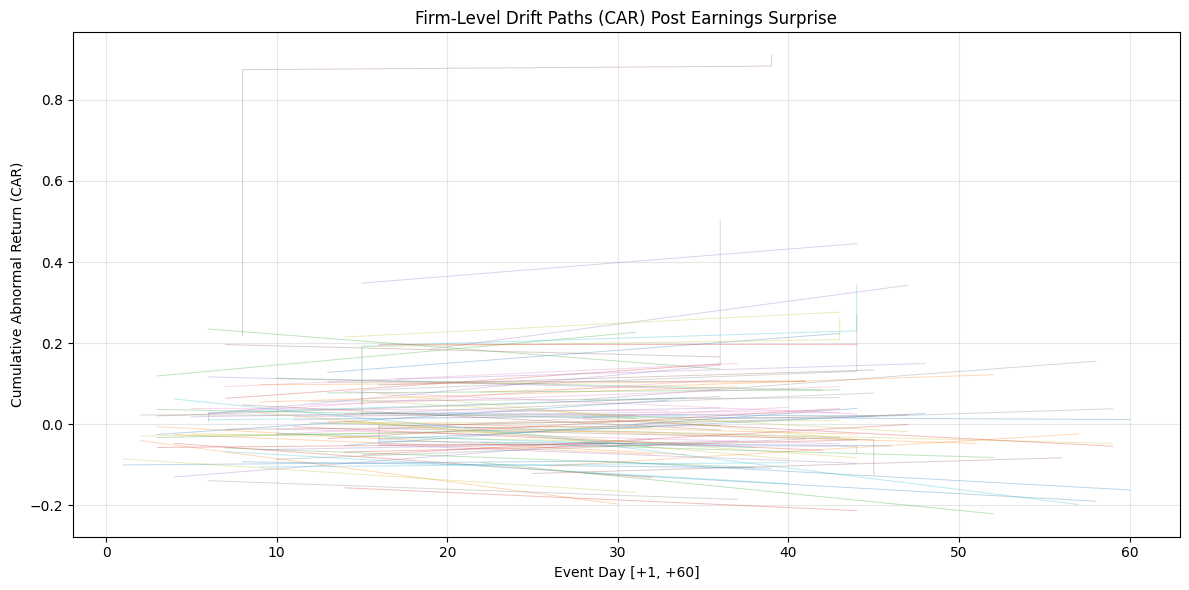

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the dataset ===
df = pd.read_excel("merged_panel_sue_ff3.xlsx")

# === Step 2: Focus only on event window [+1, +60] ===
event_window = df[(df['event_day'] >= 1) & (df['event_day'] <= 60)].copy()

# === Step 3: Compute Excess Return ===
event_window['excess_return'] = event_window['returns'] - event_window['RF']

# === Step 4: Create cumulative abnormal returns (CAR) per firm-event ===
# Optional: filter extreme outliers if needed
event_window = event_window.dropna(subset=['excess_return', 'decile_8q'])

# === Step 5: Plot CAR lines for random firms across deciles ===
# Keep only a sample of firms for visual clarity (e.g. 100 random permno-quarter pairs)
sample_keys = (
    event_window.groupby(['permno', 'quarter'])
    .size()
    .reset_index()
    .sample(n=100, random_state=42)[['permno', 'quarter']]
)

# Merge back with event window
sample_data = pd.merge(event_window, sample_keys, on=['permno', 'quarter'])

# === Step 6: Sort data for plotting ===
sample_data.sort_values(by=['permno', 'quarter', 'event_day'], inplace=True)

# === Step 7: Plotting ===
plt.figure(figsize=(12, 6))
for (firm, qtr), sub_df in sample_data.groupby(['permno', 'quarter']):
    sub_df = sub_df.sort_values('event_day')
    sub_df['car'] = sub_df['excess_return'].cumsum()
    plt.plot(sub_df['event_day'], sub_df['car'], alpha=0.3, linewidth=0.7)

plt.title("Firm-Level Drift Paths (CAR) Post Earnings Surprise")
plt.xlabel("Event Day [+1, +60]")
plt.ylabel("Cumulative Abnormal Return (CAR)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# STEP 1: Load the IBES-based merged file
ibes_df = pd.read_excel("merged_ibes_crsp_returns.xlsx")  # Update path if needed

# STEP 2: Check column names
print("Columns:", ibes_df.columns.tolist())

# STEP 3: Filter Top and Bottom SUE Deciles (D10 vs D1)
# Assume column 'SUE' exists and deciles were calculated already
ibes_df['sue_decile'] = pd.qcut(ibes_df['SUE'], 10, labels=False) + 1
d1 = ibes_df[ibes_df['sue_decile'] == 1]
d10 = ibes_df[ibes_df['sue_decile'] == 10]

# STEP 4: Calculate cumulative returns [+1, +60] for each firm if not already done
# If already available, use them directly
car_d1 = d1.groupby('PERMNO')['Returns'].sum()
car_d10 = d10.groupby('PERMNO')['Returns'].sum()


# STEP 6: T-test
t_stat, p_value = ttest_ind(car_d10, car_d1, alternative='greater')

print("=== Hypothesis Test: CAR_D10 > CAR_D1 (IBES) ===")
print(f"Mean CAR (D10): {car_d10.mean():.4f}")
print(f"Mean CAR (D1): {car_d1.mean():.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value (one-sided): {p_value:.4f}")
print(f"Observations in D10: {len(car_d10)}, D1: {len(car_d1)}")


Columns: ['PERMNO', 'Names Date', 'Share Code', 'Exchange Code', 'Ticker Symbol', 'Price or Bid/Ask Average', 'Volume', 'Returns', 'Shares Outstanding', 'Value-Weighted Return-incl. dividends', 'anndats_act', 'SUE', 'fpedats']
=== Hypothesis Test: CAR_D10 > CAR_D1 (IBES) ===
Mean CAR (D10): 0.2752
Mean CAR (D1): 0.0342
T-statistic: 3.3860
P-value (one-sided): 0.0005
Observations in D10: 51, D1: 52


In [93]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Step 1: Load IBES-CRSP merged file
df_ibes = pd.read_excel("merged_ibes_crsp_returns.xlsx")

# Step 2: Select and rename relevant columns
df_ibes_clean = df_ibes[['PERMNO', 'fpedats', 'Returns', 'SUE']].dropna()
df_ibes_clean = df_ibes_clean.rename(columns={'Returns': 'CAR'})

# Step 3: Create firm and time fixed effect dummies
df_ibes_clean['firm_fe'] = df_ibes_clean['PERMNO'].astype('category')
df_ibes_clean['time_fe'] = df_ibes_clean['fpedats'].astype('category')

# Step 4: Run Fixed Effects Model
model_fe_ibes = smf.ols(formula='CAR ~ SUE + C(firm_fe) + C(time_fe)', data=df_ibes_clean).fit()

# Step 5: Output Summary
print("\n=== Fixed Effects Regression: IBES SUE ===")
print(model_fe_ibes.summary())

# Optional: Clean reporting
print("\nCoefficient on SUE:", round(model_fe_ibes.params['SUE'], 4))
print("P-value on SUE:", round(model_fe_ibes.pvalues['SUE'], 4))
print("R-squared:", round(model_fe_ibes.rsquared, 4))



=== Fixed Effects Regression: IBES SUE ===
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.343
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           2.24e-86
Time:                        22:48:25   Log-Likelihood:             4.7270e+05
No. Observations:              188388   AIC:                        -9.447e+05
Df Residuals:                  188046   BIC:                        -9.413e+05
Df Model:                         341                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------